# Greedy Search and MCMC

The [Model Fitting via SMC](@ref) section of the [Overview](@ref) tutorial showed how to learn the structure of Gaussian process time series models by using sequential Monte Carlo structure learning.  This tutorial will illustrate two alternative structure discovery methods:

1. Greedy search ([`AutoGP.fit_greedy!`](@ref))
2. MCMC sampling ([`AutoGP.fit_mcmc!`](@ref))

In [1]:
import AutoGP
import CSV
import Dates
import DataFrames
import Distributions

using AutoGP.GP
using PyPlot: plt

The synthetic data generated below is the same as the data used in the [Inspecting Online Inference](@ref) tutorial.

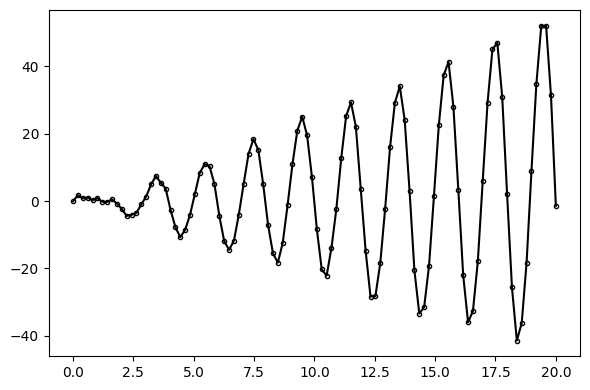

In [2]:
AutoGP.seed!(2)
cov = (Linear(1,0,50) * Periodic(5,2)) + GammaExponential(1,1)
noise = .1
n = 100

ds = Vector{Float64}(range(0, 20, length=n))
dist = Distributions.MvNormal(cov, noise, Float64[], Float64[], ds)
y = Distributions.rand(dist);

fig, ax = plt.subplots(figsize=(6, 4), dpi=100, tight_layout=true)
ax.plot(ds, y, marker=".", markerfacecolor="none", markeredgecolor="k", color="black");

## Greedy Search

To perform greedy search, the `model::GPModel` object must have a single particle.  Moreover, greedy search does not currently supported [`AutoGP.GP.ChangePoint`](@ref) covariance structures.  We can disable changepoints by using a custom [`AutoGP.GP.GPConfig`](@ref), as shown below.

In [3]:
model = AutoGP.GPModel(ds, y; n_particles=1, config=GP.GPConfig(changepoints=false));

Greedy search also supports callback functions to inspect inference.  The callback function below will be invoked at each stage of the greedy search.  We will plot [AIC](https://en.wikipedia.org/wiki/Akaike_information_criterion) at each stage and the corresponding covariance structure.

In [4]:
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(15, 15), dpi=150)
axs = permutedims(axs)
fig.set_tight_layout(true)
plt.close(fig)

function fn_callback(; kwargs...)
    model = kwargs[:model]
    step = kwargs[:step]
    aic = kwargs[:aic]
    
    ds_query = vcat(model.ds, (20:.1:30))
    predictions = AutoGP.predict(model, ds_query; quantiles=[0.025, 0.975])
    
    axs[step].scatter(model.ds, model.y, marker="o", color="k", s=10, label="Observed Data")    
    axs[step].axvline(model.ds[end], color="red", linestyle="--")
    axs[step].plot(predictions[!,:ds], predictions[!,:y_mean], linewidth=1, color="k")
    axs[step].fill_between(
        predictions[!,:ds],
        predictions[!,"y_0.025"],
        predictions[!,"y_0.975"],
        color="tab:green",
        alpha=.25)

    io = IOBuffer()
    cov = AutoGP.covariance_kernels(model)[1]
    Base.show(io, MIME("text/plain"), cov)
    cov_str = String(take!(io))
    axs[step].set_title("Step $(step)\nAIC:$(aic)\n$(cov_str)", ha="left")
end

fn_callback (generic function with 1 method)

The plots below show a key shortcoming of greedy search.  Whereas steps 3--8 contain a sensible covariance structure, at steps 9--10 the structure becomes worse.  This behavior is a result of greedy search selecting covariance structures with the smallest AIC, which is a rough heuristic to an ideal scoring function based on the [marginal likelihood](https://en.wikipedia.org/wiki/Marginal_likelihood) of the data under each structure, integrating out the parameter.  Since AIC is based on maximum likelihood estimation and the likelihood of parameters is highly multimodal for structures such as [`AutoGP.GP.Periodic`](@ref), greedy search may result in brittle and unpredictable behavior.

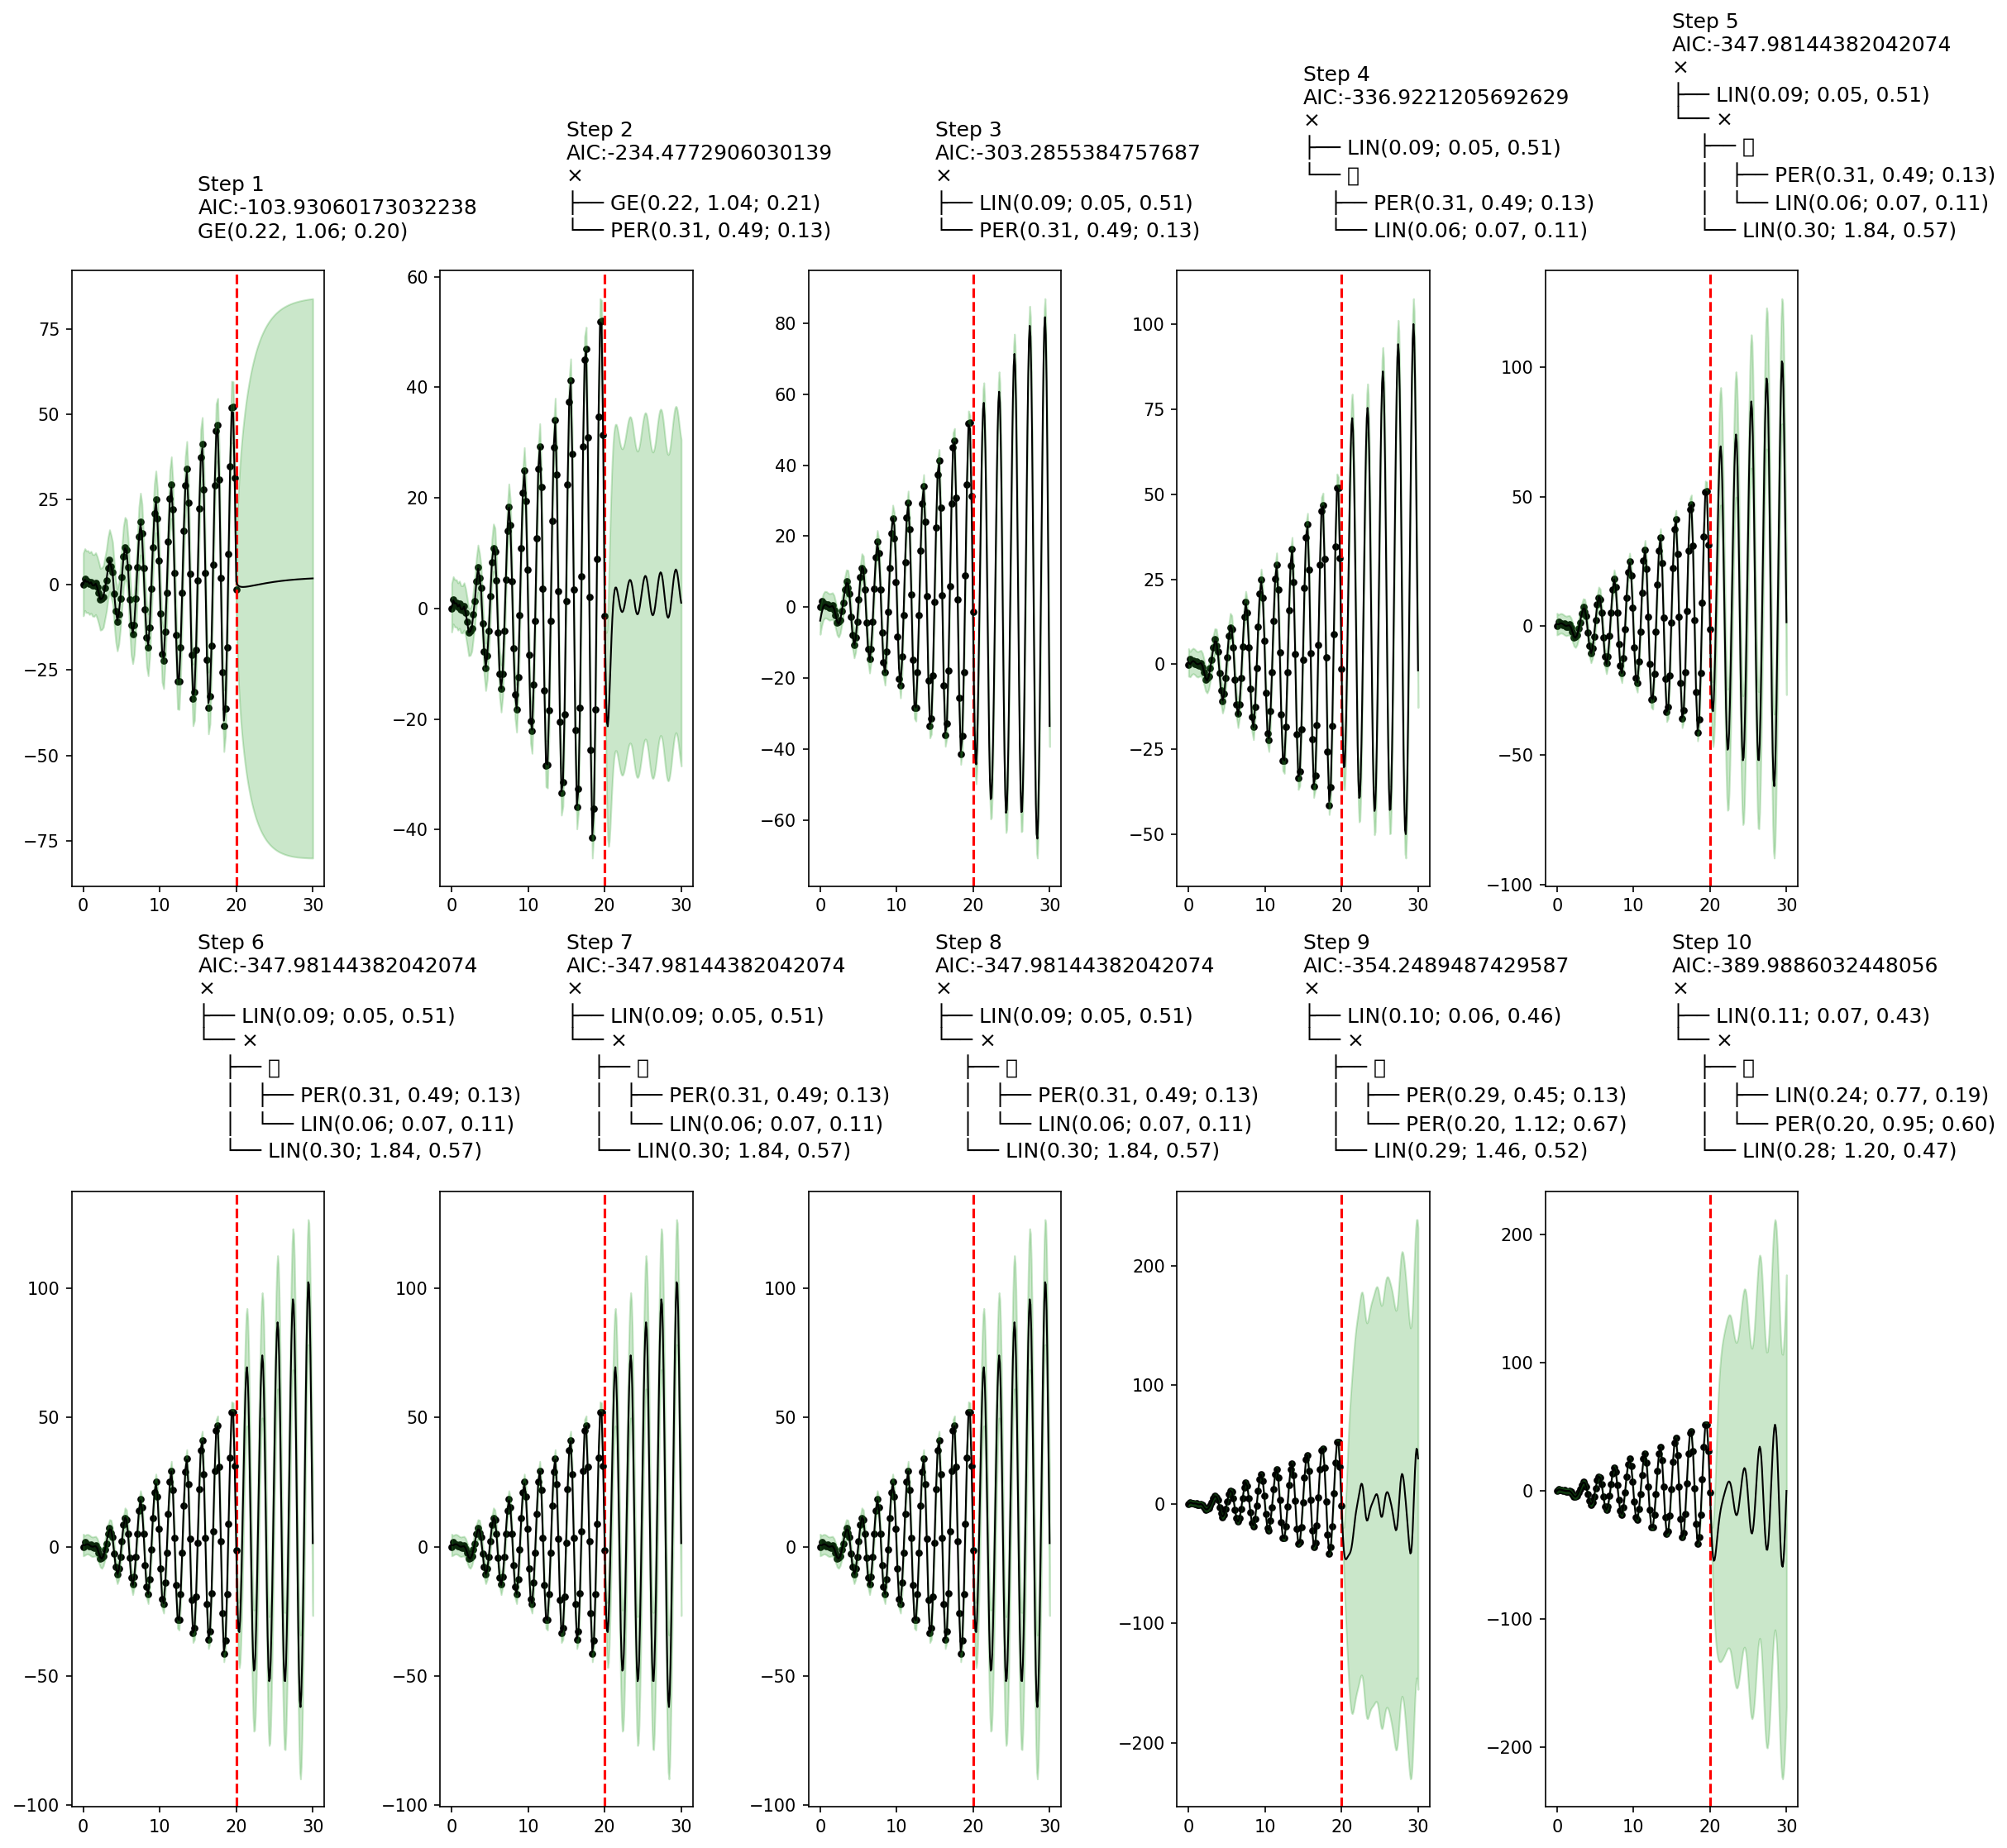

sys:1: UserWarning: Glyph 65291 (\N{FULLWIDTH PLUS SIGN}) missing from current font.


In [5]:
AutoGP.fit_greedy!(model; max_depth=10, callback_fn=fn_callback);
fig

## MCMC

Markov chain Monte Carlo sampling is another structure learning method. Let us initialize a `GPModel` with 2 particles.

In [6]:
model = AutoGP.GPModel(ds, y; n_particles=2);

In [7]:
figures = []
function fn_callback(; kwargs...)
    model = kwargs[:model]
    step = kwargs[:step]

    ds_query = vcat(model.ds, (20:.1:100))
    predictions = AutoGP.predict(model, ds_query; quantiles=[0.025, 0.975])
    
    fig, axis = plt.subplots(ncols=2, figsize=(18, 6), dpi=200)
    for (i, ax) in enumerate(axis)
        subdf = predictions[predictions.particle.==i,:]
        ax.scatter(model.ds, model.y, marker="o", color="k", s=10, label="Observed Data")    
        ax.axvline(model.ds[end], color="red", linestyle="--")
        ax.plot(subdf[!,:ds], subdf[!,:y_mean], linewidth=1, color="k")
        ax.fill_between(
            subdf[!,:ds],
            subdf[!,"y_0.025"],
            subdf[!,"y_0.975"],
            color="tab:green",
            alpha=.25)

        io = IOBuffer()
        cov = AutoGP.covariance_kernels(model)[i]
        Base.show(io, MIME("text/plain"), cov)
        cov_str = String(take!(io))
        ax.set_title("Step $(step)\n$(cov_str)", ha="left")
    end
    push!(figures, fig)
    plt.close(fig)
end

fn_callback (generic function with 1 method)

In [8]:
AutoGP.fit_mcmc!(model, 45, 10; callback_fn=fn_callback)

Let's now show some plots that were collected by the callback during MCMC inference. The final plot shows an interesting example of how MCMC learning can reflect posterior uncertainty over the covariance structure.

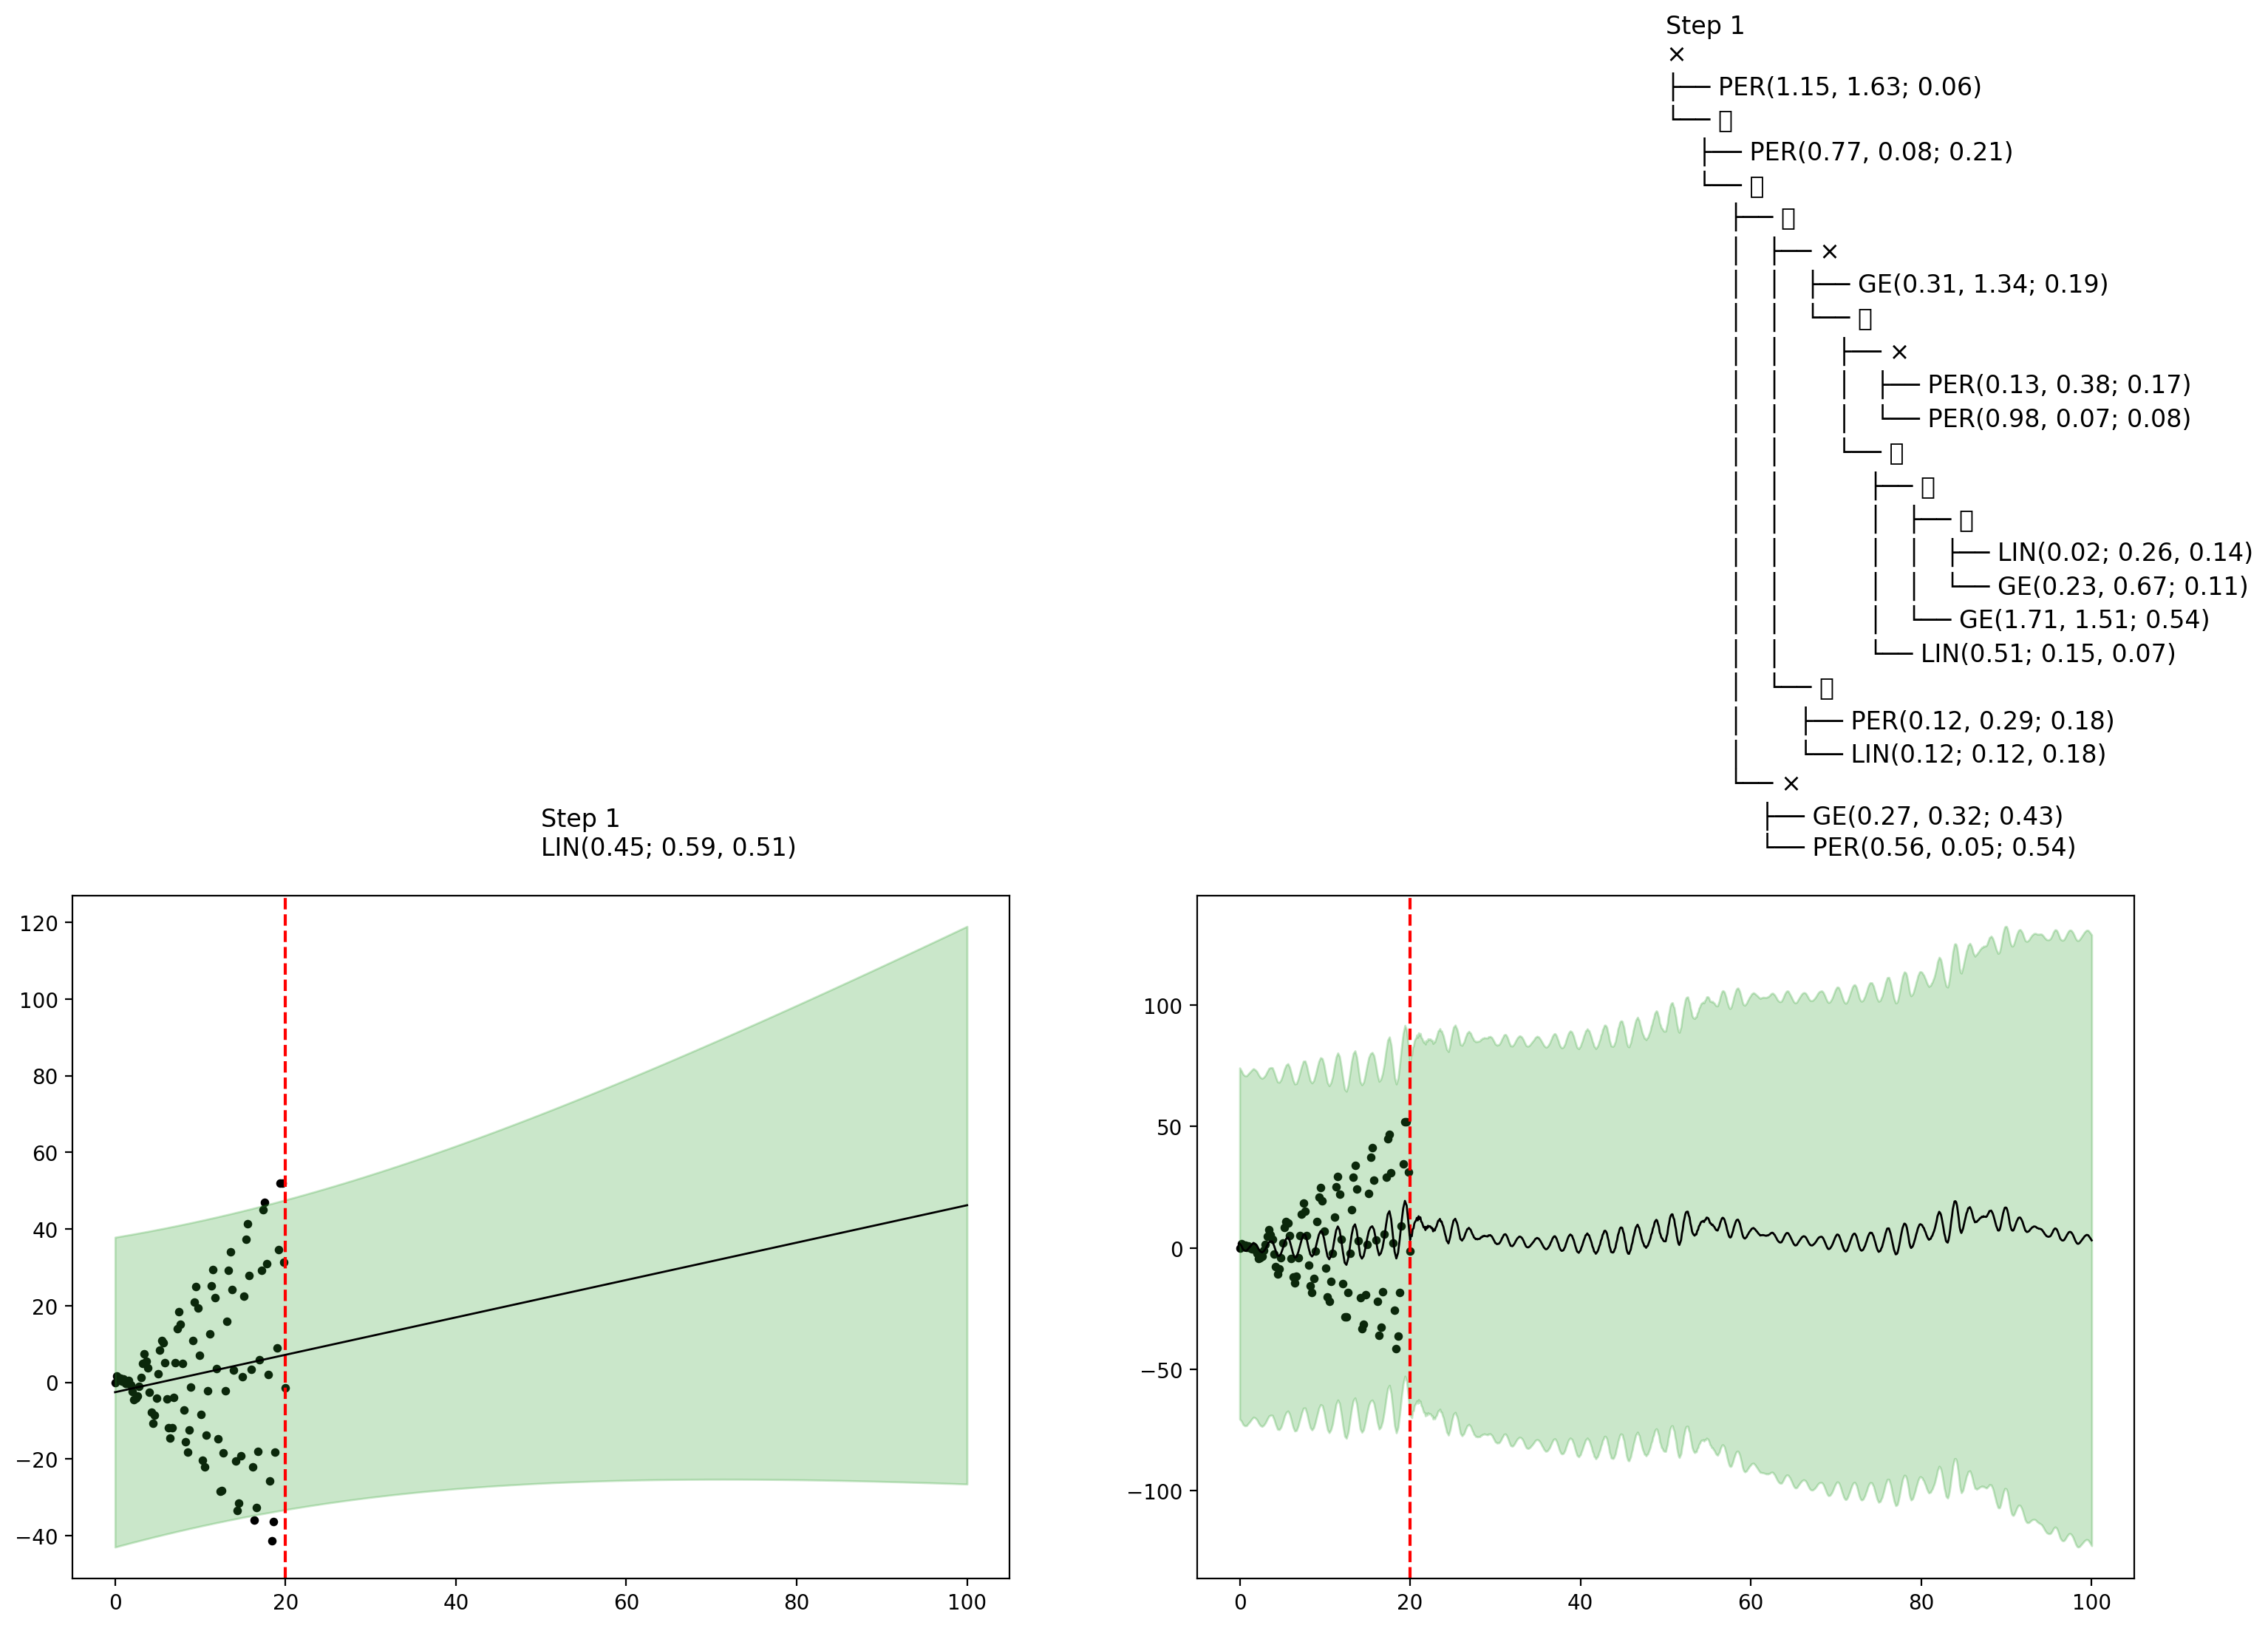

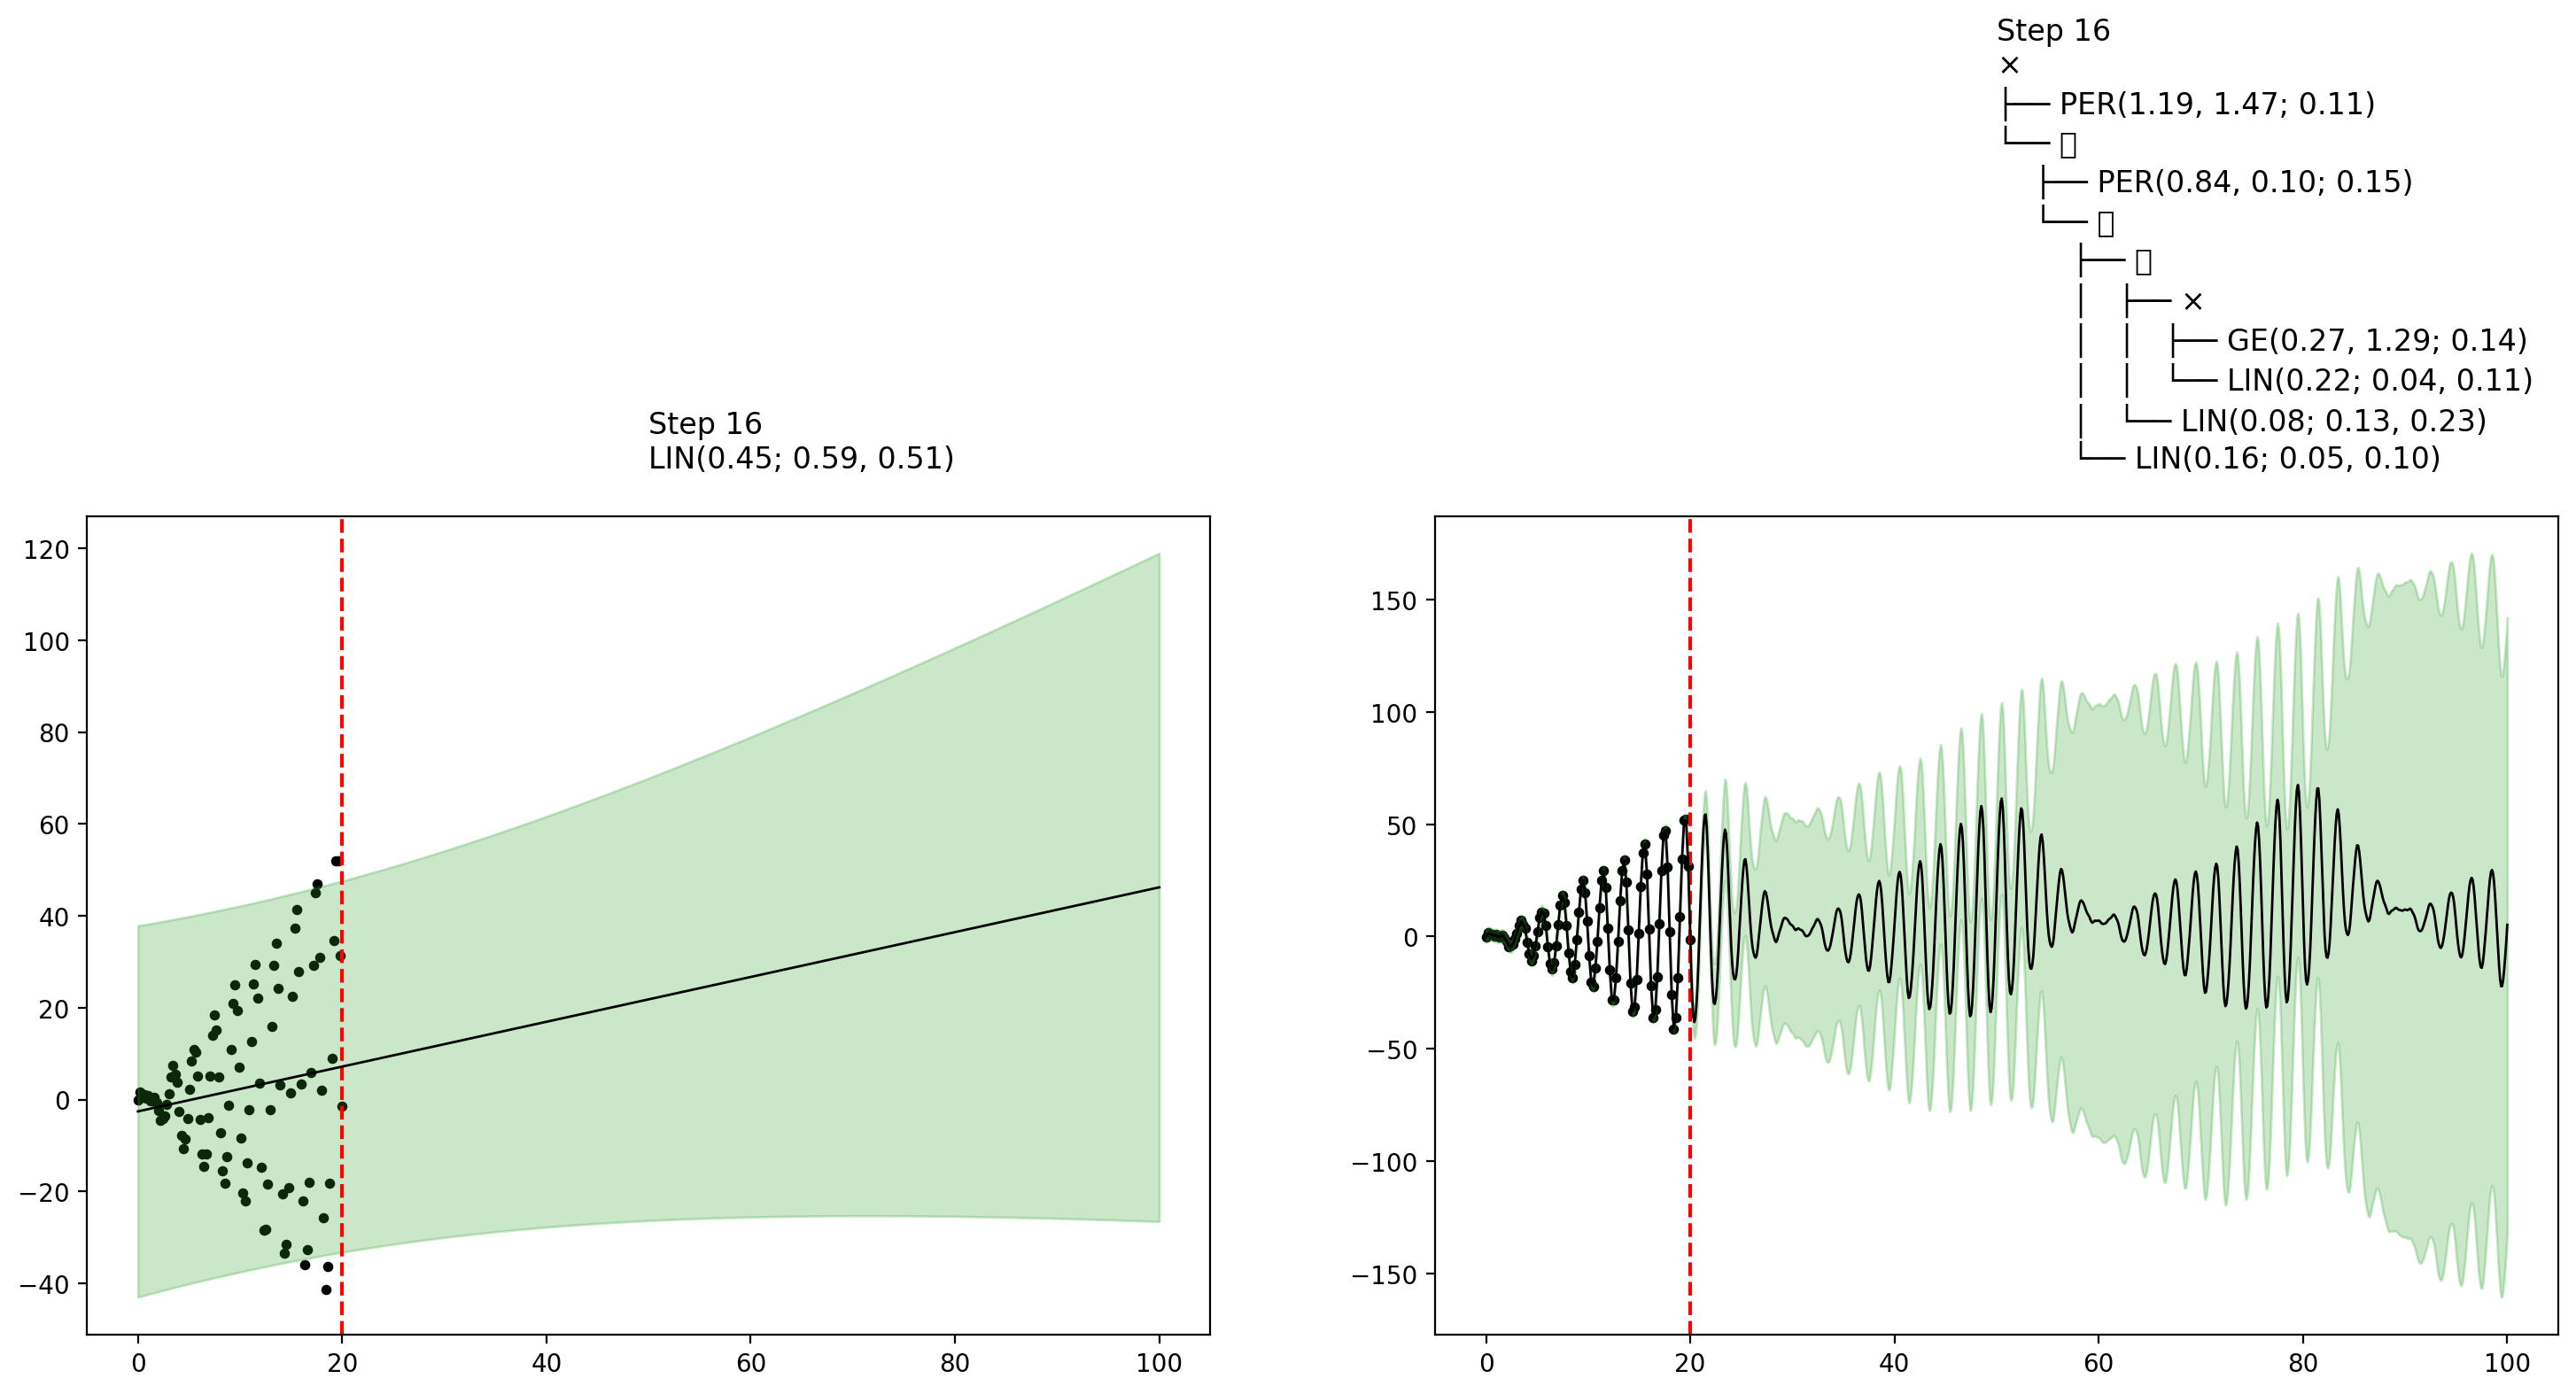

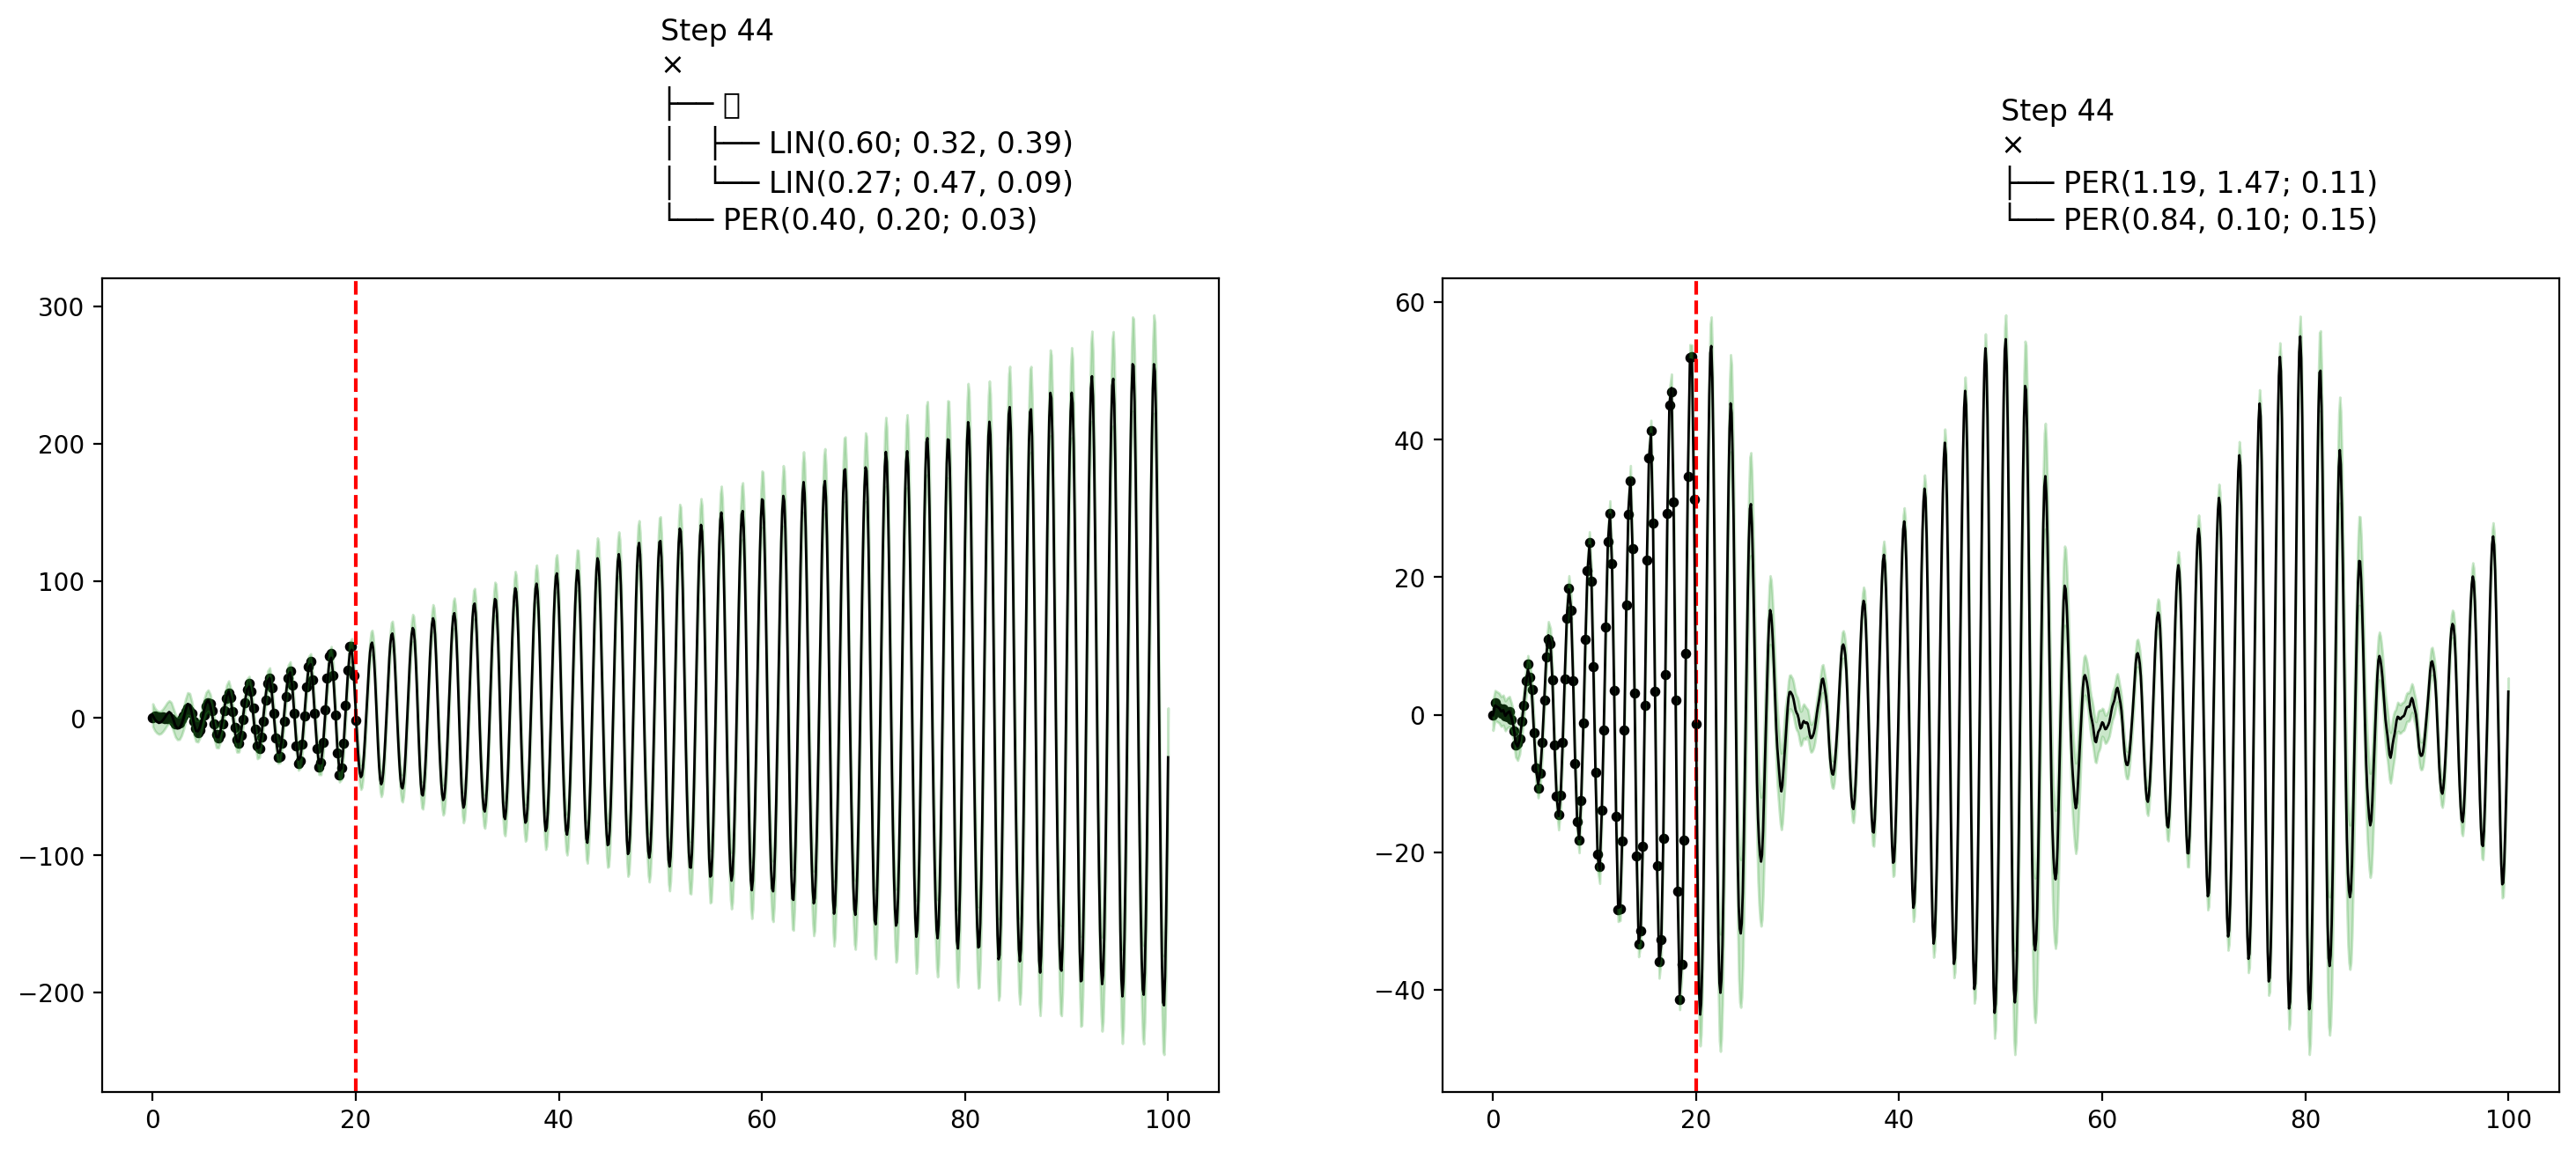

In [9]:
display(figures[1])
display(figures[10])
display(figures[end])

### MCMC vs SMC

MCMC sampling using [`fit_mcmc!`] invokes the same transition kernels over structure and parameters as those used in particle rejuvenation step of [`AutoGP.fit_smc!`](@ref).  The fundamental difference is that [`AutoGP.fit_smc!`](@ref) anneals the posterior over subsets of data at each step, whereas [`AutoGP.fit_mcmc!`](@ref) uses the full data at each step.

The benefits of SMC include

1. Runtime efficiency in cases where the structure can be quickly inferred using a subset of the data; whereas MCMC always conditions on the full data at each step yielding more expensive likelihood evaluations.
2. Principled online inference, by using [`AutoGP.add_data!`](@ref); whereas MCMC is an offline method.
3. Particle resampling, by using [`AutoGP.maybe_resample!`](@ref), to redirect computational effort to more promising structures and parameters; whereas MCMC iterates independent particles (i.e., chains).
4. The availability of unbiased marginal likelihood estimates (via [`AutoGP.log_marginal_likelihood_estimate`](@ref); whereas the marginal likelihood estimate obtained from MCMC is essentially importance sampling the posterior using the prior as a proposal.